<h1 style="color:skyblue;font-weight:700;font-size:3rem;">SMS Spam Classifier</h1>

# Importing Libraries
Importing the necessary libraries and downloading the required corpora

In [1]:
import re
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score as cv_score

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

### Downloading the `wordnet` corpora

In [ ]:
nltk.download('wordnet')

# Loading Data

In [3]:
df = pd.read_csv(r'spam.csv', encoding="iso-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


This dataset contains `5572` text messages in **English** that have been classified as either **ham** or **spam**.

## Modifying the columns
* **Dropping** the redundant unnecessary columns
* **Renaming** the `v1` and `v2` columns to `label` and `sms`

In [5]:
df.drop(df.columns[2:].values, axis=1, inplace=True)
df.rename(columns={"v1": "label", "v2": "sms"}, inplace=True)

df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Exploratory Data Analysis

## Data exploration
Checking whether or not the dataset is **imbalanced** based on count of labels

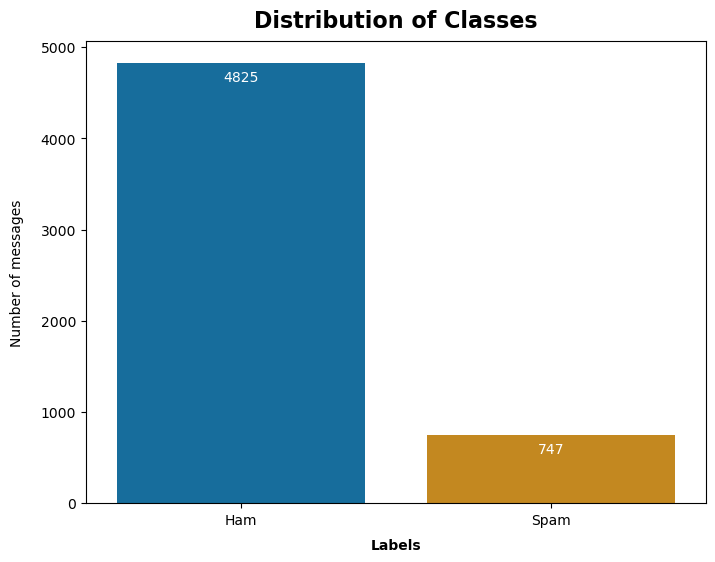

In [6]:
plt.style.use(plt.style.available[12])

fig = plt.figure(figsize=(8, 6))
fig = sns.countplot(x=df['label'], palette=sns.color_palette('colorblind'))

fig.set_title("Distribution of Classes", fontdict={'fontsize':16, 'fontweight':'bold'}, pad=10)
for container in fig.containers:
    fig.bar_label(container, label_type='edge', color='#fff', padding=-15)

fig.set_ylabel("Number of messages", labelpad=12, fontsize=10)
fig.set_xlabel("Labels", labelpad=8, fontsize=10, fontweight='bold')
fig.set_xticks([0, 1], ["Ham", "Spam"])

plt.show()

**Observation :** The imbalance in the quite evident, with `4825` **Ham** and only `747` **Spam** messages.

## Feature engineering
Creating the following features for EDA :
1. `n_characters` - Number of characters in a message
2. `n_sentences` - Number of sentences in a message
3. `n_words` - Number of words in a sentence

In [7]:
df['n_characters'] = df.sms.apply(len)
df['n_sentences'] = df.sms.apply(lambda row: sent_tokenize(row)).apply(len)
df['n_words'] = df.sms.apply(lambda row: word_tokenize(row)).apply(len)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
n_characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
n_sentences,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0
n_words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0


## Detecting outliers
Finding out the outliers in the dataset

#### PAIRPLOT

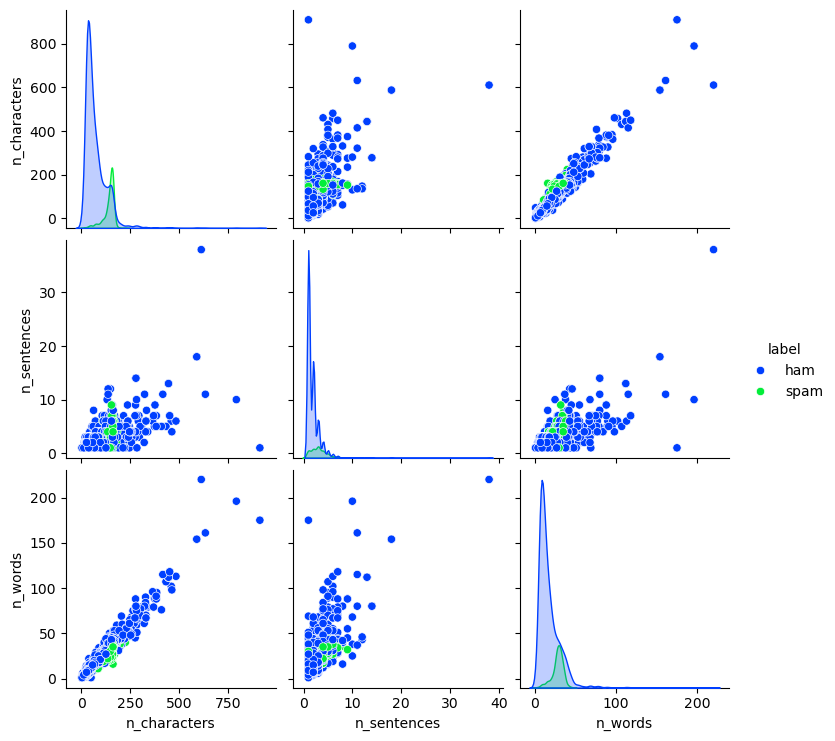

In [8]:
sns.pairplot(data=df, hue='label')
plt.show()

A lot of outliers are observable under the **ham** class in the above plot.

#### BOXPLOT

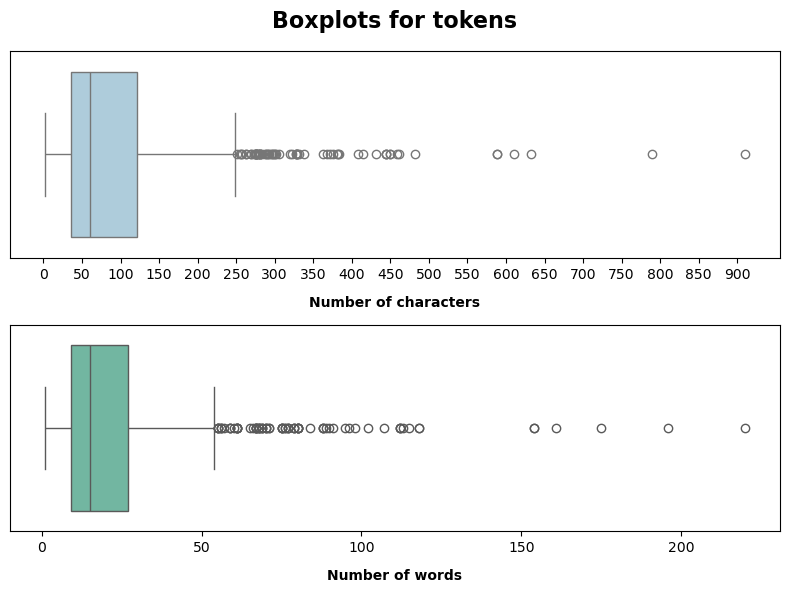

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=False)
fig.suptitle("Boxplots for tokens", size=16, weight='bold')

sns.boxplot(x='n_characters', data=df, palette=sns.color_palette('Paired'), ax=ax[0])
ax[0].set_xlabel("Number of characters", size=10, labelpad=10, fontweight='bold')
ax[0].set_yticks([])
ax[0].set_xticks([i for i in range(0, 950, 50)])

sns.boxplot(x='n_words', data=df, palette=sns.color_palette('Set2'), ax=ax[1])
ax[1].set_xlabel("Number of words", size=10, labelpad=10, fontweight='bold')
ax[1].set_yticks([])

plt.tight_layout()
plt.show()

The outliers can be dropped by capping the values of the `n_characters` column at `300` or `250`.

## Dropping outliers
Capping at `250` characters

In [10]:
data = df[df.n_characters < 250]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5504 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label         5504 non-null   object
 1   sms           5504 non-null   object
 2   n_characters  5504 non-null   int64 
 3   n_sentences   5504 non-null   int64 
 4   n_words       5504 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 258.0+ KB


Now, there are `5504` messages left in the dataset.

#### PAIRPLOT

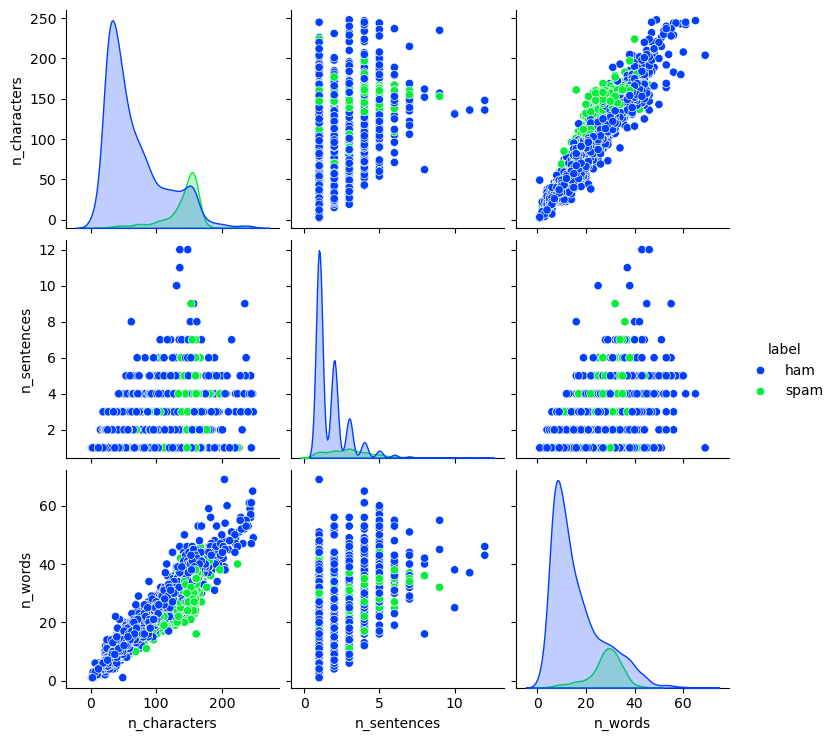

In [11]:
sns.pairplot(data, hue='label')
plt.show()

# Data Preprocessing

## Data cleaning
- **Replacing** all the non-alphanumeric characters with spaces
- **Converting** all the characters to `lowercase`

In [12]:
def clean_sms(sms: str) -> str:
    x = re.sub(r'[^a-zA-Z]', ' ', sms).strip()
    x = map(lambda word: word.strip().lower(), x.split(' '))
    cleaned_sms = ' '.join([word for word in x if word != ''])
    return cleaned_sms

data.sms = data.sms.apply(clean_sms)
for sms in data.sms.head().values:
    print(sms)

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


## **Tokenization**
Tokenizing the **words** in each of the `sms` entries

In [13]:
data['tokenized_sms'] = data.sms.apply(lambda row: word_tokenize(row))

for t_sms in data.tokenized_sms.head().values:
    print(t_sms, end='\n\n')

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']

['ok', 'lar', 'joking', 'wif', 'u', 'oni']

['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']

['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']

['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']



## **Stopword** removal
Removing the default **stopwords** from the `tokenized_sms` values

In [14]:
stops = set(stopwords.words("english"))
data['non_stop_sms'] = data.tokenized_sms.apply(lambda row: [word for word in row if word not in stops])

print(f'SMS : "{data.sms.loc[0]}"\n\nTokenized SMS length\t: {len(data.tokenized_sms.loc[0])}\nNon-stopword SMS length\t: {len(data.non_stop_sms.loc[0])}')

SMS : "go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat"

Tokenized SMS length	: 20
Non-stopword SMS length	: 16


## **Lemmatization**
Extracting the root word or **lemma** from each word based on `v` POS tag i.e. **verbal** part of speech

In [15]:
lemmatizer = WordNetLemmatizer()

def lemmatize_sms(words: pd.Series) -> list[str]:
    lemmas = [lemmatizer.lemmatize(word, pos='v') for word in words]
    return lemmas

data['lemma_sms'] = data['non_stop_sms'].apply(lemmatize_sms)

for l_sms in data.lemma_sms.head().values:
    print(l_sms, end='\n\n')

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']

['ok', 'lar', 'joke', 'wif', 'u', 'oni']

['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']

['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']

['nah', 'think', 'go', 'usf', 'live', 'around', 'though']



## **Vectorization**
Converting the words into **vectors** for transforming the data into a **numerical** format using the **TF-IDF** method

### Building the **corpus** 
Building a corpus from the **lemmatized** text messages

In [16]:
corpus = data['lemma_sms'].apply(lambda row: ' '.join(row))

corpus[:5]

0    go jurong point crazy available bugis n great ...
1                                ok lar joke wif u oni
2    free entry wkly comp win fa cup final tkts st ...
3                  u dun say early hor u c already say
4                  nah think go usf live around though
Name: lemma_sms, dtype: object

### Applying **vectorization**
Obtaining the **feature vectors** from the corpus

In [17]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus).toarray()

X.shape

(5504, 6333)

### Encoding **labels**
Applying `LabelEncoder` to the message labels

In [18]:
encoder = LabelEncoder()
data.label = encoder.fit_transform(data.label)

data.label.head()

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int32

# Model Training

## Target and features
Splitting up the **target** and the **features** from the dataset

In [19]:
y = data.label
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=33)

X_train.shape, X_test.shape

((4403, 6333), (1101, 6333))

## Model pipeline
Fitting the **training** data on a pipeline of models and obtaining their **cross-validation** scores

In [20]:
pipeline = {
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(warm_start=True, max_iter=200, n_jobs=-1),
    'Decision Tree Classifier': DecisionTreeClassifier(max_depth=20, max_leaf_nodes=100),
    'Random Forest Classifier': RandomForestClassifier(warm_start=True, n_estimators=35, n_jobs=-1)
}

print("Cross-validation scores - Mean accuracy\n")

for name, model in pipeline.items():
    model.fit(X_train, y_train)
    score = cv_score(model, X_train, y_train, scoring='accuracy', cv=10)
    print(f"{name} : {(score.mean() * 100):.2f}%")

Cross-validation scores - Mean accuracy

Gaussian Naive Bayes : 86.17%
Logistic Regression : 95.71%
Decision Tree Classifier : 95.82%
Random Forest Classifier : 97.68%


The `RandomForestClassifer` model gave the **highest** mean accuracy score on `10` folds of **training** data.

# Model Evaluation

## Classification reports
Evaluating the performance of the models on the **testing** dataset

In [21]:
preds = {}
labels=['Ham', 'Spam']

def report(*args):
    print(f"{args[0]}\n")
    y_pred = args[1].predict(X_test)
    preds.update({args[0] : y_pred})
    
    print(classification_report(y_test.astype('int'), y_pred))
    print(f"Accuracy score : {(accuracy_score(y_test.astype('int'), y_pred) * 100):.2f}%", end='\n\n')

for i, item in enumerate(pipeline.items()):
    report(*item)
    if i != len(pipeline) - 1:
        print()

Gaussian Naive Bayes

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       952
           1       0.53      0.91      0.67       149

    accuracy                           0.88      1101
   macro avg       0.76      0.89      0.80      1101
weighted avg       0.92      0.88      0.89      1101

Accuracy score : 87.74%


Logistic Regression

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       952
           1       0.99      0.75      0.85       149

    accuracy                           0.97      1101
   macro avg       0.98      0.88      0.92      1101
weighted avg       0.97      0.97      0.96      1101

Accuracy score : 96.55%


Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       952
           1       0.93      0.83      0.88       149

    accuracy                           0.97      1101
   macr

## **Result**
From the classification reports, it is clear that `RandomForestClassifier` offers the **highest** accuracy (~**98**%) on the testing data.

## Confusion matrices
Plotting the **confusion matrix** for each model's prediction

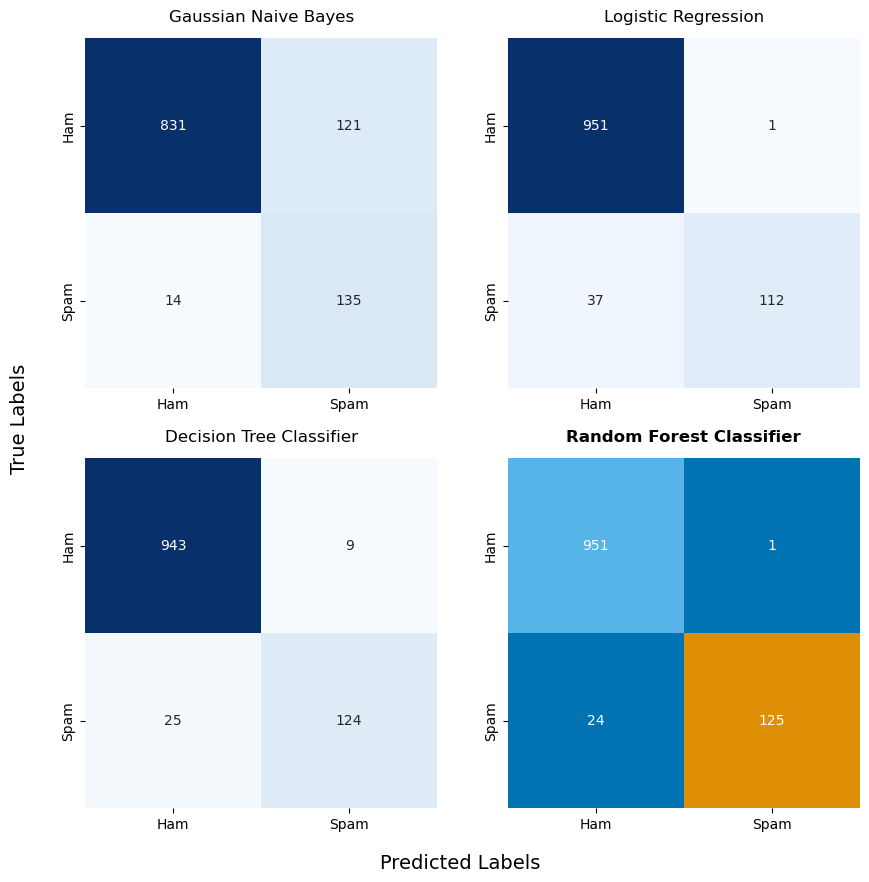

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.text(0.5, 0.05, 'Predicted Labels', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'True Labels', va='center', rotation='vertical', fontsize=14)

for ax, (name, model) in zip(axs.flatten(), pipeline.items()):
    cm = confusion_matrix(y_test, preds[name])
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cbar=False, cmap=sns.color_palette('colorblind', as_cmap=True) if name == 'Random Forest Classifier' else 'Blues')
    
    ax.set_title(f"{name}", pad=12, fontweight='bold' if name == 'Random Forest Classifier' else 'light', fontsize=12)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

plt.show()

## Pickling
Pickling the **vectorizer** and the `RandomForestClassifier` model in `.pkl` format

In [23]:
model_filename = r'rfc-model.pkl'
vectorizer_filename = r'tfidf-vectorizer.pkl'

pickle.dump(pipeline['Random Forest Classifier'], open(model_filename, 'wb'))
pickle.dump(vectorizer, open(vectorizer_filename, 'wb'))

## Testing
Testing the pickled model on **sample** spam message

In [24]:
loaded_model = pickle.load(open(model_filename, 'rb'))
loaded_vectorizer = pickle.load(open(vectorizer_filename, 'rb'))

loaded_model

RandomForestClassifier(n_estimators=35, n_jobs=-1, warm_start=True)

In [25]:
sample = "Want to win $5,000 in this summer’s treasure hunt? Text “YES” to 4555 to reserve your ticket.T&Cs apply."

vector = loaded_vectorizer.transform([sample]).toarray()
pred_label = "HAM" if loaded_model.predict(vector.reshape(1, -1))[0] == 0 else "SPAM"

print(f"""
SMS message\t: "{sample}"
True label\t: SPAM
Predicted label\t: {pred_label}
""")


SMS message	:  "Want to win $5,000 in this summer’s treasure hunt? Text “YES” to 4555 to reserve your ticket.T&Cs apply. "
True label	:  SPAM
Predicted label	:  SPAM

